# Tlamatini: Digitalizing Mexican Indigenous Languages

How can we direct the power of machine learning towards uniting the human race and celebrate our differences at the same time?

During a hackathon AI4Good, my team and I decided to tackle the problem of 'Eliminating language barriers'.
Our specific use case, was to create a machine translation algorithm to translate sentences from Spanish to Nahuatl. Nahuatl is the former language of the Aztecs, the dominant civilization in Mexico before the Spanish Empire conquered the region. Nahuatl is spoken still in Mexico by 1.5 million people. Tlamatini means wise man in Nahuatl and is a project directed to digitalize Mexican Indigenous Languages.

Machine translation systems like Google Translate or Microsoft Translate are already used by millions of people in the world in order to break language barriers. A person using these algorithms can translate any sentence between a great variety of languages: English, Spanish, German, Chinese, Japananese even Mayan! But I have not seen a Machine Tranlation system to Nahuatl. So this was certainly an interesting challenge. Creating this algorithm would be a way to immortalize the language of the Aztecs.

# Hackathon first attempt (Neural Machine Translation)

Our first attempt was to use the most famous translation algorithm in the past decade: neural machine translation (NMT). This is the algorithm that made machine translation get so much better in the past years.

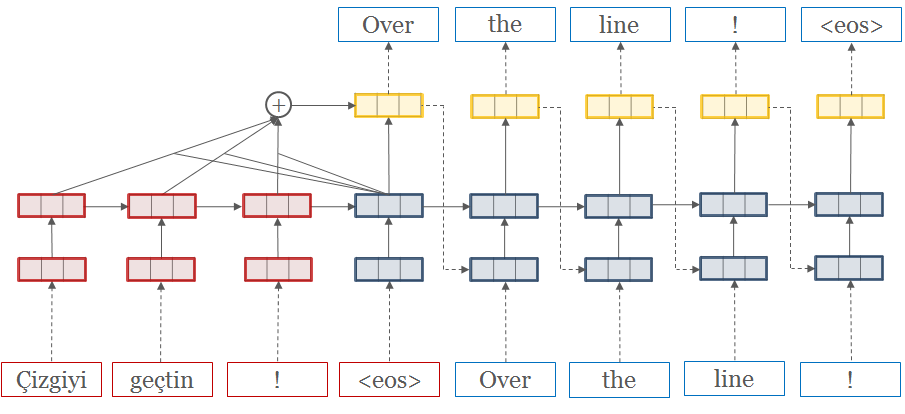

In [3]:
from IPython.display import Image
Image(filename='nmt.png')

NMT works in the following way: we get a lot of sentences in Spanish and their respective translations in Nahuatl. Then these sentences would be used by the algorithm to learn to translate by adjusting the paramaters of the algorithm. It would learn the different patterns in the data and how words and phrases map to another language. However, the problem is that you need a lot of clean data to do this.

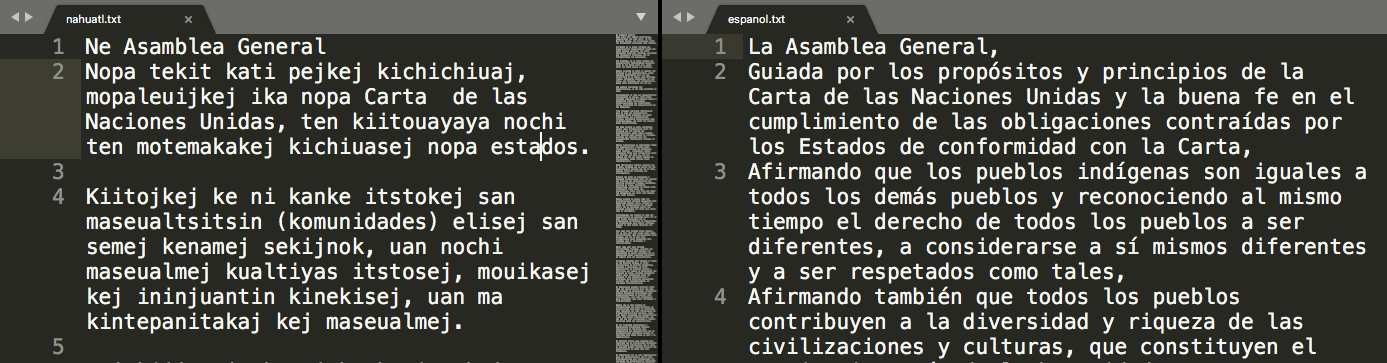

In [5]:
Image(filename='data_collection.png')

To have a successful translation model using NMT, you need at least tens of thousands of sentences translated. I was able to collect around 8,000 sentences by combining the United Nations Declaration of Human Rights, the Mexican Consitution and some Aztec literature. However, I realized that the algorithm required a clean one-to-one mapping between the sentences of both languages. And doing this would require a great amount of effort and understanding of both languages (which I don't have).

So the data collection aspect is crucial for this undertaking. One idea to create a clean dataset, is to crowdsource it and make a way for people around Mexico to help us build it. If we could make a simpler initial model that people could try to use for translation and could correct in case of mis-translation, then we could use this data to train a proper NMT model.

# From NMT to MUSE: Aligning word embeddings

After the Hackathon, I decided to continue the project with my friends Ines and Fabio. We decided to create a simpler initial model that we could use as a baseline for the data collecting system. I also discovered that Facebook had word embeddings in both Spanish and Nahuatl trained on Wikipedia that we could leverage.
https://fasttext.cc/docs/en/crawl-vectors.html

Word embeddings are a way of representing words as vectors. You can think of this as each word being a list of numbers or each word being a point of space. However, this vectors are adjusted based on real text so that they capture the 'meaning' or the context of a word in a document. More importanty, with Facebook's MUSE library (Multilingual Unsupervised and Supervised Embeddings) we could align the embeddings of two different languages in order to create a bilingual dictionary.

https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

https://github.com/facebookresearch/MUSE

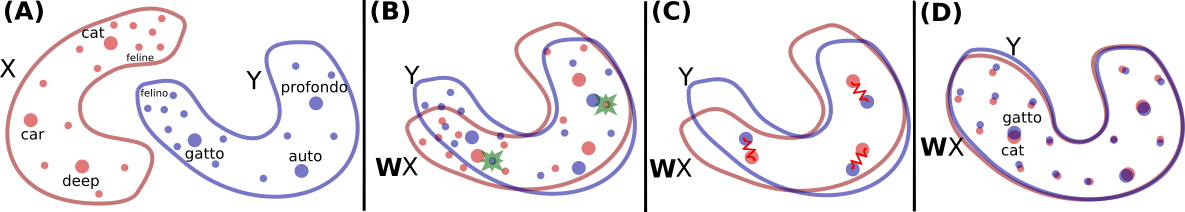

In [6]:
Image(filename='muse.png')

Each embedding has more than 20,000 words. So we could use a small dictionary of words (like cat-gatto, car-auto, deep-profondo in the image) to align the embeddings. Thanks to the structure that we learned in the embeddings, this should be enough to get a good bilingual dictionary

I created a dictionary of 350 words from Spanish to Nahuatl using the following webpage as a reference.
https://nawatl.com/
Then I used MUSE to align the embeddings that I got from Facebook project FastText. Each embeddings was trained on Wikipedia articles of the respective language. The aligned embeddings get saved into a txt file that I will show next.

In [7]:
import io
import numpy as np

In [8]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [9]:
src_path = '/Users/belanger/MUSE/dumped/debug/fyoxhk7bs4/vectors-es.txt'
tgt_path = '/Users/belanger/MUSE/dumped/debug/fyoxhk7bs4/vectors-nah.txt'

nmax = 20000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

Let's see some of the words in the embeddings

In [20]:
list(src_word2id.keys())[120:140]

['sur',
 '?',
 'mayor',
 'según',
 'tiempo',
 'provincia',
 'partido',
 'contra',
 'encuentra',
 'municipio',
 'otras',
 'and',
 'todos',
 'juan',
 'sido',
 'josé',
 'bajo',
 'serie',
 'cada',
 'fútbol']

In [21]:
list(tgt_word2id.keys())[120:140]

['ahnozo',
 'cah',
 'yehhuatl',
 'is',
 'tlein',
 'l',
 'le',
 'hacer',
 'tlācatiyān',
 'ītōca',
 'this',
 'for',
 'mētztli',
 'reverso',
 'n',
 'tōnalli',
 'me',
 'nitetla',
 'lugar',
 'canahpa']

We can see that the word embeddings in Nahuatl contain a lot of words in English and Spanish. We will analyze this afterwards. For now, lets try to predict translation given a word. To do this, we will look for the nearest neighbors of a source word embedding in the target embedding space.

# Get nearest neighbors

In [23]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [26]:
# printing nearest neighbors in the source space
src_word = 'casa'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "casa":
1.0000 - casa
0.6271 - mansión
0.6115 - habitación
0.5726 - casona
0.5692 - casas


In [29]:
# printing nearest neighbors in the target space
src_word = 'casa'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "casa":
0.6130 - chantli
0.5831 - apantli
0.5760 - yeyantli
0.5698 - nantli
0.5484 - tzaucpantli


The word 'chantli' in Nahuatl means 'casa' in Spanish, so we are off to a good start :)
However, the pair ('casa'-'chantli') was one of the pairs used for training. So this just confirms that we are learning the words that we add into the dictionary. We must try with words that are not contained in the dictionary. Let's try the word 'amor' (Love)

In [30]:
# printing nearest neighbors in the target space
src_word = 'amor'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "amor":
0.6462 - obispo
0.5542 - daré
0.5541 - páramo
0.5525 - arzobispo
0.5432 - aaba


According to my research, the correct translation should be 'tetlazohtlaliztli', but we get predictions in Spanish although we are searching in the target embedding. This is probably because the articles in Nahuatl Wikipedia contain a lot of terms in Spanish and even English. Let's quantify this as a way of evaluating the FastText Facebook embeddings.

# Evaluating embeddings with language detection

An interesting experiment would be to evaluate how many of the words in the embeddings are actually of the language that they claim to be. It's clear that Nahuatl has evolved in a Spanish speaking country and that we live in a planet where English is our lingua franca, but let's see to what extent is this true. We will use the langid package to do the language identification. It doesn't have Nahuatl as a option for language detection, but it has 97 languages including English and Spanish.
https://github.com/saffsd/langid.py


In [33]:
import langid
spanish_words = list(src_word2id.keys())
nahuatl_words = list(tgt_word2id.keys())

In [34]:
from collections import Counter
spanish_wikipedia_labels = []
for spanish_word in spanish_words:
    try:
        language, score = langid.classify(spanish_word)
        spanish_wikipedia_labels.append(language)
    except:
        print("unable to classify")
print(spanish_wikipedia_labels[100:120])

['es', 'es', 'en', 'en', 'en', 'es', 'fr', 'es', 'en', 'fr', 'en', 'en', 'en', 'en', 'en', 'es', 'en', 'hu', 'es', 'en']


In [36]:
counter_spanish = Counter(spanish_wikipedia_labels)
print(counter_spanish.most_common(8))

[('en', 8452), ('es', 5765), ('de', 705), ('fr', 631), ('hu', 597), ('it', 473), ('gl', 455), ('pt', 438)]


We can see that even the embedding for Spanish contains more words that were identified as English than Spanish! Although the second most common by a big margin is Spanish. Let's see what happens with Nahuatl!

In [37]:
nahuatl_wikipedia_labels = []
for nahuatl_word in nahuatl_words:
    try:
        language, score = langid.classify(nahuatl_word)
        nahuatl_wikipedia_labels.append(language)
    except:
        print("unable to classify")
print(nahuatl_wikipedia_labels[100:120])

['en', 'lv', 'en', 'en', 'en', 'lv', 'en', 'en', 'en', 'en', 'lv', 'en', 'es', 'en', 'en', 'pl', 'en', 'es', 'en', 'en']


In [38]:
counter_nahuatl = Counter(nahuatl_wikipedia_labels)
print(counter_nahuatl.most_common(8))

[('en', 7870), ('es', 3860), ('de', 1211), ('lv', 833), ('fr', 590), ('it', 530), ('eu', 495), ('hu', 387)]


In the nahuatl case, we can see that more than 50% of the words are identified as English or Spanish. 
With this experiments we can see how languages that are different share a lot of words at least in Wikipedia entries. This leads to suggest that maybe Wikipedia entries are not a very clean source of text for the translations.

# Conclusion

The data collection is the real challenge of this project. We need to find the appropriate sources of information to get data as clean, aligned and real as possible! :D

# Next steps

Get bilingual dictionaries as big as possible like: http://www.gdn.unam.mx/termino/search

Investigate parallel corpus to include into the dictionary or even to train a NMT like:
https://axolotl-corpus.mx/ayuda

Talk to specialists or native speakers to make sure our data is adequate. Would be useful to brainstorm with them about possible sources of information or unexpensive ways to create these.

# Extra: Visualize word embeddings

A way to evaluate if you word embeddings are aligned is by visualizing pairs of translated words in both languages! If the multilingual word embedding was well aligned, then the corresponding words should be close to each other.

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.09


In [43]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

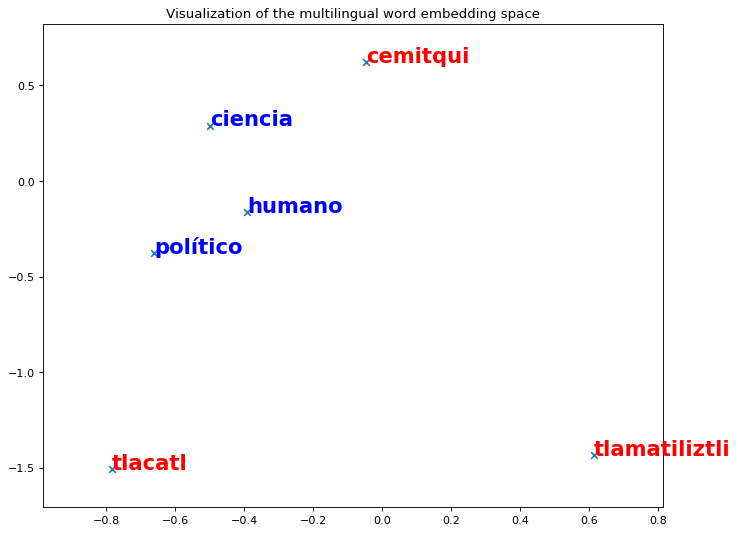

In [41]:
# get 5 random input words
#src_words = ['amigo', 'sabio', 'hombre', 'mujer', 'profesor', 'estudiante']
#tgt_words = ['ikniwtli', 'tlamatini', 'okichtli', 'siwatl',  'temachtiani', 'temachtili']

src_words = ['ciencia', 'humano', 'político']
tgt_words = ['tlamatiliztli', 'tlacatl', 'cemitqui']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

The pair of translated words should be close to each other! I guess we still have word to do ;)